# Sandbox for QRN-RL-GNN

This is an IPython notebook to be used for the following:

1) As a sandbox to test snippets of code during development

2) For demonstration purposes of functionalities

### Imports

In [ ]:
import numpy as np
import torch 
from tqdm import tqdm
import matplotlib.pyplot as plt
from repeaters import RepeaterNetwork
from models import CNN, GNN
from gnn_environment import Environment

## Testing

## New code with cutoffs please

In [9]:
def modified_reward(net):
    """
    Add some small reward for established links. Make it as non-exploitable as possible
    so that large bonuses are only given for physically desired states
    """
    bonus_reward = 0 # some function f(d, e; n)
    for (i,j), (adjecency, entanglement) in net.matrix.items():
        distance = j-i #chain only
        bonus_reward +=  entanglement*distance**2/net.n**2 if entanglement else 0
    return bonus_reward

In [35]:
n=20
net = RepeaterNetwork(n=n)
for n in range(n-1):
    net.entangle(edge=(n, n+1))
reward = modified_reward(net)
print(f'Reward of fully entangled   : {reward:.3f}')
net.resetState()
net.setLink(edge=(1, n-1), linkType=1, newValue=1)
reward = modified_reward(net)
print(f'Reward of almost end-to-end : {reward:.3f}')

Reward of fully entangled   : 0.047
Reward of almost end-to-end : 0.640


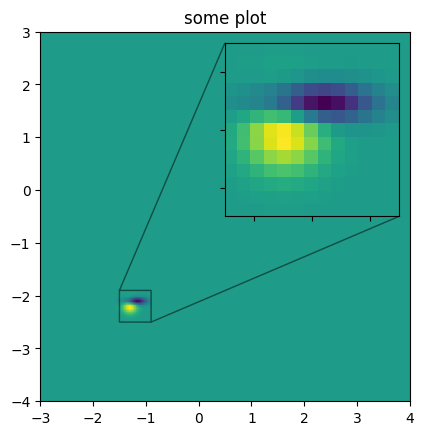

In [24]:
"""Use inset_zoom later to better probe regions of interest during training"""
from matplotlib import cbook
fig, ax = plt.subplots()

# make data
z = cbook.get_sample_data("axes_grid/bivariate_normal.npy")  # 15x15 array
z2 = np.zeros((150, 150))
ny, nx = z.shape
z2[30:30+ny, 30:30+nx] = z
extent = (-3, 4, -4, 3)

ax.imshow(z2, extent=extent, origin="lower")

# inset Axes....
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.imshow(z2, extent=extent, origin="lower")

ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_title('some plot')
plt.show()

In [3]:
model = GNN(node_dim        = 1, # always
            embedding_dim   = 16,
            num_layers      = 3,
            num_heads       = 4,
            hidden_dim      = 64, 
            unembedding_dim = 16, 
            output_dim      = 4, # always
            ) 

## Basic usage

### Basic usage 1: The Quantum repeaters

First lets initialize the network this is done with the `RepeaterNetwork` class. It is parametrized by the number of nodes $n$, the system parameters $\tau, p_e, p_s$ and some other stuff

In [ ]:
net = RepeaterNetwork(
                    n=4,
                    p_entangle = 1,
                    p_swap = 1,
                    tau = 1_000,
                    kappa = 1,
                    directed = False,
                    geometry = 'chain',
                    )

The state can be seen anytime with ```self.matrix``` (dictionary) or used with ```pyG``` with ```self.tensorState()``` (pyG.data)